In [7]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [8]:
FIL = float

with pm.Model() as model:

    AVERAGE_PAYMENT: FIL = 1.0
    STD_PAYMENT: FIL = 1.0

    # Observables
    p = pm.Gamma('payment', mu=AVERAGE_PAYMENT, sd=STD_PAYMENT)
    P_r_d2bar = pm.Uniform('P_r_d2bar', lower=0.5, upper=1)
    P_r_d2 = pm.Uniform('P_r_d2', lower=P_r_d2bar, upper=1)
    P_r_d3 = pm.Uniform('P_r_d3', lower=0.0, upper=1.0)
    P_d4_d2 = pm.Beta('P_d4_d2', mu=0.01, sd=0.01)

    # Inobservables
    N_a = pm.Gamma('N_a', mu=P_d4_d2, sd=0.005)
    alpha = pm.Uniform('alpha', lower=0.01, upper=2)

    # Parameters
    m_c = pm.Uniform('m_c', lower=0, upper=2)
    m_s = pm.Uniform('m_s', lower=0, upper=2_000)

   # Auxiliary Variables
    pi_r_C = pm.Deterministic('pi_r_C', p / alpha)
    P_d4_d3 = pm.Uniform('P_d4_d3', lower=P_r_d3, upper=1)
    P_r_d3bar = pm.Uniform('P_r_d3bar', lower=0.0, upper=P_r_d3)
    P_d4bar_d2 = pm.Deterministic('P_d4bar_d2', 1 - P_d4_d2)
    d_r = P_r_d2 - P_r_d2bar
    eq_mc = pm.Deterministic('eq_mc', (d_r + alpha + 2 * P_d4_d2 - 1) / N_a)
    eq_ms = pm.Deterministic('eq_ms', 1 / P_d4_d2 - 1)

    # Payoffs & Decisions
    pi_d1_C = pi_r_C * P_r_d2 + p * (2 * P_d4_d2 - N_a * m_c - 1)
    pi_d1_C_bar = pi_r_C * P_r_d2bar
    U_d1 = pm.Deterministic('U_d1', pi_d1_C - pi_d1_C_bar)
    d1 = pm.Deterministic('d1', U_d1 > 0)

    pi_d2_P = p * (P_d4bar_d2 - m_s * P_d4_d2)
    pi_d2_P_bar = 0.0
    U_d2 = pi_d2_P - pi_d2_P_bar
    d2 = pm.Deterministic('d2', d1 & (U_d2 > 0))

    pi_d3_C = pi_r_C * P_r_d3 + p * (P_d4_d3 - m_c)
    pi_d3_C_bar = pi_r_C * P_r_d3bar
    U_d3 = pi_d3_C - pi_d3_C_bar
    d3 = pm.Deterministic('d3', d2 & (U_d3 > 0))

    pi_d4_R = pm.Bernoulli('pi_d4_R', p=1-P_r_d3)
    pi_d4_R_bar = 0 if pi_d4_R == 1 else 0
    U_d4 = pi_d4_R - pi_d4_R_bar
    d4 = pm.Deterministic('d4', d3 & (U_d4 > 0))

    # Priors for unknown model parameters
    trace = pm.sample(draws=50_000,
                      chains=4,
                      tune=5_000,
                      nuts={'target_accept':0.99},
                      return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [P_r_d3bar, P_d4_d3, m_s, m_c, alpha, N_a, P_d4_d2, P_r_d3, P_r_d2, P_r_d2bar, payment]
>BinaryGibbsMetropolis: [pi_d4_R]


Sampling 4 chains for 5_000 tune and 50_000 draw iterations (20_000 + 200_000 draws total) took 1589 seconds.
There were 4017 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8874890678771262, but should be close to 0.99. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [9]:
print(trace.posterior.d1.sum())
print(trace.posterior.d2.sum())
print(trace.posterior.d3.sum())
print(trace.posterior.d4.sum())


<xarray.DataArray 'd1' ()>
array(11479)
<xarray.DataArray 'd2' ()>
array(1734)
<xarray.DataArray 'd3' ()>
array(1462)
<xarray.DataArray 'd4' ()>
array(653)


In [10]:
print(np.percentile(trace.posterior.eq_mc, [2.5, 50, 97.5]))
print(np.percentile(trace.posterior.eq_ms, [2.5, 50, 97.5]))

[-1.72519760e+13  1.36068457e+01  9.46181914e+17]
[  18.91274914  135.93940341 1992.10165863]


In [ ]:

df = trace.posterior.to_dataframe()

metric_0 = df.d1
metric_1 = df.d2[metric_0 == True]
metric_2 = (df.P_r_d2 / df.P_r_d2bar)[metric_0 == True]
#metric_3 = df.payment * (1 - df.P_r_d2) * df.P_d4_d2 / df.pi_r_C
#metric_4 = df.pi_d4_R_bar
metric_5 = df.pi_d4_R

In [ ]:
metric_1

In [ ]:
inds = trace.posterior.d1.values == 1
x = trace.posterior.m_s.values[inds].flatten()
y = trace.posterior.d2.values[inds].flatten()

plt.plot(x, y, '.')
plt.show()

In [11]:
def summarize_trace(trace):
    print("-- median --")
    print(trace.posterior.median())
    print("-- std --")
    print(trace.posterior.std())
    print("-- std per median -- ")
    print(trace.posterior.std() / trace.posterior.median())
    pm.plot_trace(trace)
    plt.show()

    bfmi = np.max(pm.stats.bfmi(trace))
    max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace).values()).values
    (
        pm.plot_energy(trace, legend=False, figsize=(6, 4)).set_title(
            f"BFMI = {bfmi :.2e}\nGelman-Rubin = {max_gr :.2e}"
        )
    )
    plt.show()

    pm.plot_posterior(trace)
    plt.show()
    
    pd.plotting.scatter_matrix(trace.posterior.to_dataframe(), figsize=(20, 20))
    plt.show()


-- median --
<xarray.Dataset>
Dimensions:     ()
Data variables: (12/21)
    pi_d4_R     float64 0.0
    payment     float64 0.6927
    P_r_d2bar   float64 0.7456
    P_r_d2      float64 0.9036
    P_r_d3      float64 0.5104
    P_d4_d2     float64 0.007303
    ...          ...
    eq_ms       float64 135.9
    U_d1        float64 -0.5145
    d1          float64 0.0
    d2          float64 0.0
    d3          float64 0.0
    d4          float64 0.0
-- std --
<xarray.Dataset>
Dimensions:     ()
Data variables: (12/21)
    pi_d4_R     float64 0.4999
    payment     float64 0.9913
    P_r_d2bar   float64 0.1432
    P_r_d2      float64 0.1094
    P_r_d3      float64 0.2943
    P_d4_d2     float64 0.01382
    ...          ...
    eq_ms       float64 689.0
    U_d1        float64 1.869
    d1          float64 0.2326
    d2          float64 0.09271
    d3          float64 0.08519
    d4          float64 0.05705
-- std per median -- 
<xarray.Dataset>
Dimensions:     ()
Data variables: (12/21)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: overflow encountered in square
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: overflow encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils

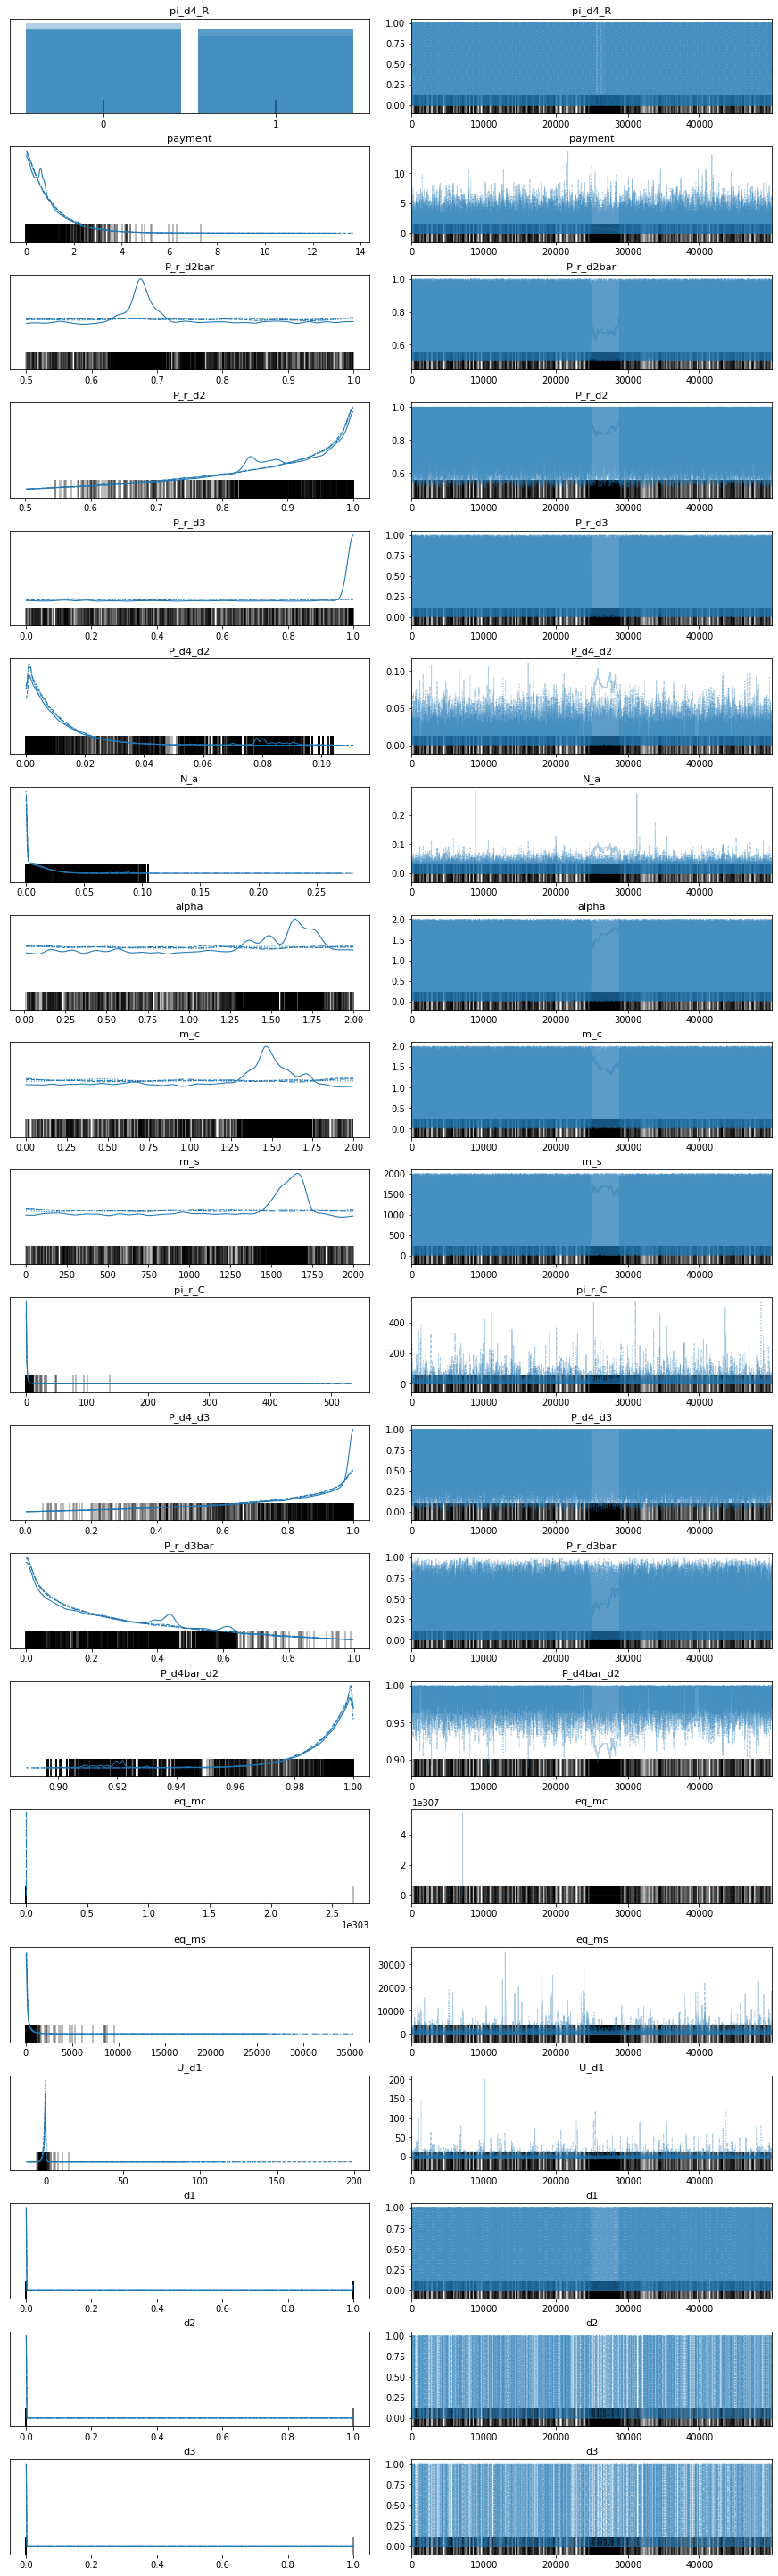

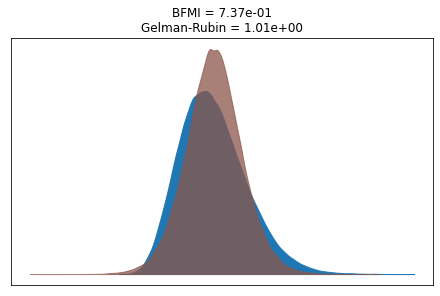

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: overflow encountered in square
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: overflow encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-

ValueError: cannot convert float NaN to integer

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


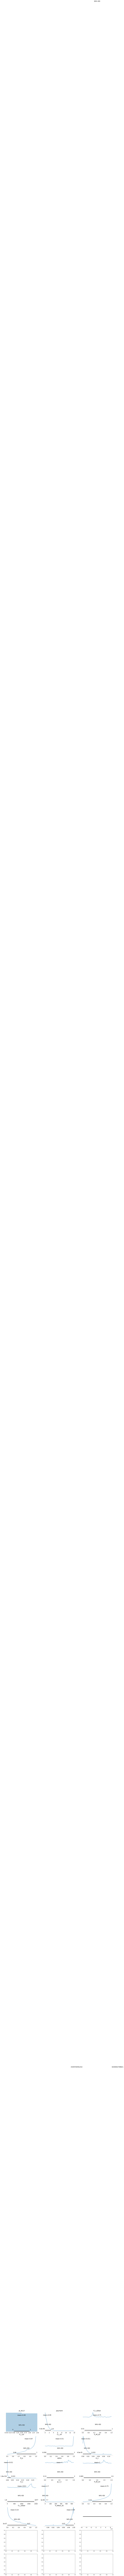

In [12]:
summarize_trace(trace)